# Libraries

In [1]:
import os, cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from glob import glob
import keras.layers as kl
from PIL import ImageFile
from keras import backend as K
from keras.layers import Layer, InputSpec
from keras.preprocessing import image
from tensorflow.keras import callbacks
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.python.platform import build_info as tf_build_info
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.layers import concatenate, Dense, Conv2D, MaxPooling2D, Flatten, Input
from tensorflow.keras.layers import Activation, add, AveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Reshape, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
ImageFile.LOAD_TRUNCATED_IMAGES = True

2025-05-14 01:57:42.891232: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747187863.135290      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747187863.207822      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
targetnames = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']
num_classes = len(targetnames)
batch_size = 16
image_size = 224
print(num_classes)

7


In [3]:
train_path = '/kaggle/input/augmentation-task-ham10000/HAM10K/Prior_Augmention/train_dir'
test_path = '/kaggle/input/augmentation-task-ham10000/HAM10K/Prior_Augmention/test_dir'
val_path = '/kaggle/input/augmentation-task-ham10000/HAM10K/Prior_Augmention/val_dir'

# Dataset generation (Train, Test, Validation)

In [4]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.densenet.preprocess_input)

In [5]:
print("\nTrain Batches: ")
train_batches = datagen.flow_from_directory(directory=train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,
                                            shuffle=True)
print("\nTest Batches: ")
test_batches = datagen.flow_from_directory(test_path,
                                          target_size=(image_size,image_size),
                                          batch_size=batch_size,
                                          shuffle=False)
print("\nVal Batches: ")
val_batches = datagen.flow_from_directory(val_path,
                                         target_size=(image_size,image_size),
                                         batch_size=batch_size,
                                         shuffle=False)


Train Batches: 
Found 43979 images belonging to 7 classes.

Test Batches: 
Found 5500 images belonging to 7 classes.

Val Batches: 
Found 5498 images belonging to 7 classes.


### Define Model

In [6]:
from tensorflow.keras.applications.densenet import DenseNet201
# Create a new instance of DenseNet201
DN201 = DenseNet201(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), pooling='avg')

I0000 00:00:1747187890.952588      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## Fine tuning

In [7]:
MainInput=Input(shape=(image_size, image_size, 3))

In [8]:
densenet = DN201(MainInput)

In [9]:
# Reshape the tensor to have 4 dimensions
from tensorflow.keras.layers import Reshape
reshape = Reshape((8, 8, 30))(densenet)

In [10]:
conv = Conv2D(filters=256,kernel_size=(7,7), activation="relu",padding="same",kernel_initializer='he_normal')(reshape)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(5,5), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(3,3), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)
conv = Conv2D(filters=256,kernel_size=(1,1), activation="relu",padding="same",kernel_initializer='he_normal')(conv)
conv = BatchNormalization()(conv)

In [11]:
conv = (Flatten()(conv))
conv = (Dense(1024,activation="relu")(conv))
conv = Dropout(0.35)(conv)
conv = (Dense(512,activation="relu")(conv))
conv = Dropout(0.25)(conv)
conv = (Dense(num_classes, activation="softmax")(conv))

model_dn201 = Model(inputs=MainInput, outputs=conv)

In [12]:
model_dn201.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet201 (Functional)             │ (None, 1920)                │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 30)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 8, 8, 256)           │         376,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 8, 8, 256)           │       1,638,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 256)           │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │      16,778,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,303,815 (146.12 MB)

 Trainable params: 38,072,711 (145.24 MB)

 Non-trainable params: 231,104 (902.75 KB)

In [13]:
opt1=tf.keras.optimizers.Adam(learning_rate=0.001,epsilon=0.1)
model_dn201.compile(optimizer=opt1,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [14]:
class_weights = {   
                    0: 1.0,  
                    1: 1.0,  
                    2: 1.0,  
                    3: 1.0,  
                    4: 1.0,  
                    5: 1.0,
                    6: 1.0
                }

In [15]:
checkpoint = ModelCheckpoint(filepath ='DN201.weights.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=True)
Earlystop = EarlyStopping(monitor='val_accuracy', mode='max', patience=15, min_delta=0.01)

In [16]:
history = model_dn201.fit(train_batches,
                         epochs=80,
                         verbose=2,
                         validation_data=val_batches,
                         callbacks=[checkpoint, Earlystop],
                         class_weight=class_weights) 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/80


I0000 00:00:1747188050.014505      78 service.cc:148] XLA service 0x7a62f4001a20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747188050.015707      78 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747188064.631648      78 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747188297.564506      78 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2749/2749 - 1180s - 429ms/step - accuracy: 0.7230 - loss: 0.7720 - val_accuracy: 0.8605 - val_loss: 0.3747
Epoch 2/80
2749/2749 - 486s - 177ms/step - accuracy: 0.8744 - loss: 0.3529 - val_accuracy: 0.8627 - val_loss: 0.3779
Epoch 3/80
2749/2749 - 488s - 177ms/step - accuracy: 0.9172 - loss: 0.2303 - val_accuracy: 0.9182 - val_loss: 0.2148
Epoch 4/80
2749/2749 - 489s - 178ms/step - accuracy: 0.9441 - loss: 0.1586 - val_accuracy: 0.9482 - val_loss: 0.1510
Epoch 5/80
2749/2749 - 482s - 175ms/step - accuracy: 0.9599 - loss: 0.1116 - val_accuracy: 0.9345 - val_loss: 0.1734
Epoch 6/80
2749/2749 - 488s - 177ms/step - accuracy: 0.9687 - loss: 0.0886 - val_accuracy: 0.9318 - val_loss: 0.2079
Epoch 7/80
2749/2749 - 494s - 180ms/step - accuracy: 0.9741 - loss: 0.0749 - val_accuracy: 0.9520 - val_loss: 0.1269
Epoch 8/80
2749/2749 - 494s - 180ms/step - accuracy: 0.9805 - loss: 0.0554 - val_accuracy: 0.9658 - val_loss: 0.0937
Epoch 9/80
2749/2749 - 490s - 178ms/step - accuracy: 0.9824 - loss: 0.0533

In [17]:
model_dn201.save('DN_Model.h5')

### Plotting accuracy and loss

Number of epochs trained: 30


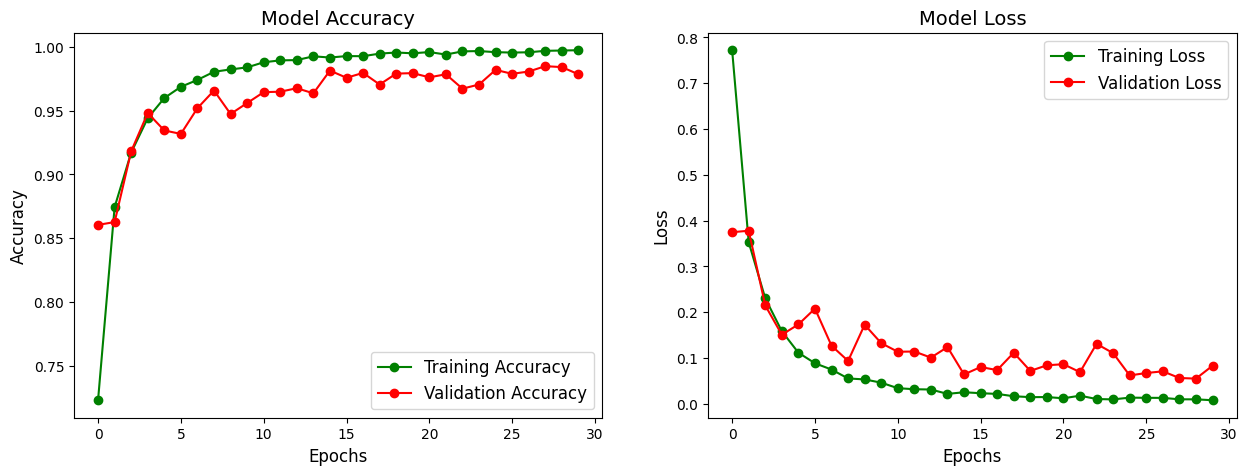

In [18]:
# Determine number of epochs trained
num_epochs_trained = len(history.history['val_loss'])
print(f"Number of epochs trained: {num_epochs_trained}")

## History plotting
epochs = [i for i in range(num_epochs_trained)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(15,5)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
ax[0].set_title('Model Accuracy', fontdict=title_font)
legend_font = {'family': 'Times New Roman', 'size': '12', 'weight': 'normal'}
ax[0].legend(prop=legend_font)
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}
ax[0].set_xlabel("Epochs",  fontdict=label_font)
ax[0].set_ylabel("Accuracy",  fontdict=label_font)

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Model Loss', fontdict=title_font)
ax[1].legend(prop=legend_font)
ax[1].set_xlabel("Epochs", fontdict=label_font)
ax[1].set_ylabel("Loss", fontdict=label_font)
plt.show()

In [19]:
from tensorflow.keras import models
model_dn201.load_weights("DN201.weights.h5")

In [20]:
predictions = model_dn201.predict(test_batches)

344/344 ━━━━━━━━━━━━━━━━━━━━ 94s 211ms/step


In [21]:
#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
#getting the true labels per image 
y_true = test_batches.classes
#getting the predicted labels per image 
y_prob = predictions

In [22]:
classnames = ['AKIEC', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'VASC']

from tensorflow.keras.utils import to_categorical
y_test = to_categorical(y_true)

report = classification_report(y_true, y_pred, target_names=classnames)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

       AKIEC       0.99      1.00      1.00       800
         BCC       0.99      1.00      1.00       789
         BKL       0.98      0.99      0.98       797
          DF       1.00      1.00      1.00       781
         MEL       0.97      0.97      0.97       796
          NV       0.97      0.94      0.96       801
        VASC       1.00      1.00      1.00       736

    accuracy                           0.99      5500
   macro avg       0.99      0.99      0.99      5500
weighted avg       0.99      0.99      0.99      5500



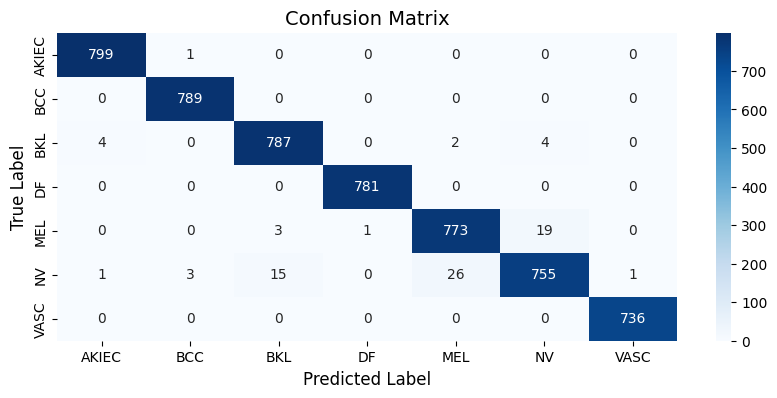

In [23]:
## Confusion Matrix
title_font = {'fontname':'Times New Roman', 'size':'14', 'color':'black', 'weight':'normal'}
label_font = {'fontname':'Times New Roman', 'size':'12', 'color':'black', 'weight':'normal'}

from sklearn.metrics import confusion_matrix
import seaborn as sns
# Creating confusion matrix 
cm = confusion_matrix(y_true, y_pred)
# Plotting the confusion matrix
plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=targetnames, yticklabels=targetnames)
plt.xlabel('Predicted Label', fontdict=label_font)
plt.ylabel('True Label', fontdict=label_font)
plt.title('Confusion Matrix', fontdict=title_font)
plt.show()

## Results

### Individual Class Accuracy 

In [24]:
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
accuracy = accuracy_score(y_true, y_pred)
# Calculate accuracy for each class
class_accuracy = cm.diagonal()/cm.sum(axis=1)
print("Overall accuracy: {:.2f}%".format(accuracy*100))
print("Accuracy for each class:")
for i, acc in enumerate(class_accuracy):
    print("Class {}: {:.2f}%".format(i, acc*100))

Overall accuracy: 98.55%
Accuracy for each class:
Class 0: 99.88%
Class 1: 100.00%
Class 2: 98.75%
Class 3: 100.00%
Class 4: 97.11%
Class 5: 94.26%
Class 6: 100.00%


### Individual Class Weighted Precision

In [25]:
report = classification_report(y_true, y_pred, output_dict=True)
# Extract weighted precision for each class
class_precision = {}
for class_label in report.keys():
    if class_label == 'weighted avg':
        class_precision['weighted'] = report[class_label]['precision']
    elif class_label.isdigit():
        class_precision[int(class_label)] = report[class_label]['precision']
print("Weighted precision for each class:")
for i, precision in class_precision.items():
    if i == 'weighted':
        print("Weighted precision: {:.2f}%".format(precision*100))
    else:
        print("Class {}: {:.2f}%".format(i, precision*100))

Weighted precision for each class:
Class 0: 99.38%
Class 1: 99.50%
Class 2: 97.76%
Class 3: 99.87%
Class 4: 96.50%
Class 5: 97.04%
Class 6: 99.86%
Weighted precision: 98.54%


### Individual Class Weighted Recall

In [26]:
report = classification_report(y_true, y_pred, output_dict=True)
# Extract weighted recall for each class
class_recall = {}
for class_label in report.keys():
    if class_label == 'weighted avg':
        class_recall['weighted'] = report[class_label]['recall']
    elif class_label.isdigit():
        class_recall[int(class_label)] = report[class_label]['recall']
print("Weighted recall for each class:")
for i, recall in class_recall.items():
    if i == 'weighted':
        print("Weighted Recall: {:.2f}%".format(recall*100))
    else:
        print("Class {}: {:.2f}%".format(i, recall*100))

Weighted recall for each class:
Class 0: 99.88%
Class 1: 100.00%
Class 2: 98.75%
Class 3: 100.00%
Class 4: 97.11%
Class 5: 94.26%
Class 6: 100.00%
Weighted Recall: 98.55%


### Individual Class Weighted F1-score

In [27]:
report = classification_report(y_true, y_pred, output_dict=True)
# Extract weighted F1-score for each class
class_f1 = {}
for class_label in report.keys():
    if class_label == 'weighted avg':
        class_f1['weighted'] = report[class_label]['f1-score']
    elif class_label.isdigit():
        class_f1[int(class_label)] = report[class_label]['f1-score']
print("Weighted F1-score for each class:")
for i, f1_score in class_f1.items():
    if i == 'weighted':
        print("Weighted F1-score: {:.2f}%".format(f1_score*100))
    else:
        print("Class {}: {:.2f}%".format(i, f1_score*100))

Weighted F1-score for each class:
Class 0: 99.63%
Class 1: 99.75%
Class 2: 98.25%
Class 3: 99.94%
Class 4: 96.81%
Class 5: 95.63%
Class 6: 99.93%
Weighted F1-score: 98.54%


### Individual Class Precision, Recall and F1-score

In [28]:
from sklearn.metrics import precision_recall_fscore_support

precision_class, recall_class, f1_class, support_class = precision_recall_fscore_support(y_true, y_pred, average=None)
print('Class-wise weighted precision, recall, and F1-score:')
for i in range(len(precision_class)):
    print('Class {}: Precision={:.2f}, Recall={:.2f}, F1-score={:.2f}'.format(i, precision_class[i], recall_class[i], f1_class[i]))


Class-wise weighted precision, recall, and F1-score:
Class 0: Precision=0.99, Recall=1.00, F1-score=1.00
Class 1: Precision=0.99, Recall=1.00, F1-score=1.00
Class 2: Precision=0.98, Recall=0.99, F1-score=0.98
Class 3: Precision=1.00, Recall=1.00, F1-score=1.00
Class 4: Precision=0.97, Recall=0.97, F1-score=0.97
Class 5: Precision=0.97, Recall=0.94, F1-score=0.96
Class 6: Precision=1.00, Recall=1.00, F1-score=1.00


### Individual Class Weighted Sensitivity

In [29]:
from sklearn.metrics import recall_score

# Calculate class-wise sensitivity
sensitivity = recall_score(y_true, y_pred, average=None)

print("Weighted sensitivity for each class:")
# Print sensitivity score for each class
for i in range(len(sensitivity)):
    print("Class {}: sensitivity = {:.2f}".format(i, sensitivity[i]))

# Calculate weighted sensitivity (recall)
sensitivity = recall_score(y_true, y_pred, average='weighted')
print("Weighted Sensitivity: {:.2f}".format(sensitivity))

Weighted sensitivity for each class:
Class 0: sensitivity = 1.00
Class 1: sensitivity = 1.00
Class 2: sensitivity = 0.99
Class 3: sensitivity = 1.00
Class 4: sensitivity = 0.97
Class 5: sensitivity = 0.94
Class 6: sensitivity = 1.00
Weighted Sensitivity: 0.99


### Individual Class Weighted Specificity

In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Assuming y_true and y_pred are defined from your previous code
cm = confusion_matrix(y_true, y_pred)

# Initialize lists to store specificity for each class
specificity_per_class = []

print("Weighted specificity for each class:")
# Calculate specificity for each class
for i in range(len(cm)):
    # True Negatives (TN): Sum of all elements except the i-th row and i-th column
    tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
    # False Positives (FP): Sum of i-th column excluding the diagonal element
    fp = cm[:, i].sum() - cm[i, i]
    # Specificity = TN / (TN + FP)
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    specificity_per_class.append(specificity)
    print(f"Class {i}: specificity = {specificity:.2f}")

# Calculate weighted specificity
# Weight by the number of true instances for each class
class_counts = cm.sum(axis=1)
total_count = class_counts.sum()
weighted_specificity = np.sum([spec * count / total_count for spec, count in zip(specificity_per_class, class_counts)])
print(f"Weighted Specificity: {weighted_specificity:.2f}")

Weighted specificity for each class:
Class 0: specificity = 1.00
Class 1: specificity = 1.00
Class 2: specificity = 1.00
Class 3: specificity = 1.00
Class 4: specificity = 0.99
Class 5: specificity = 1.00
Class 6: specificity = 1.00
Weighted Specificity: 1.00


### Accuracy

In [31]:
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))
import numpy as np
from sklearn.metrics import accuracy_score

Accuracy: 0.9854545454545455


In [32]:
# Calculate top-1 accuracy
top1_acc = accuracy_score(y_true, y_pred)
print("Top-1 Accuracy:", top1_acc)

# Calculate top-2 accuracy
y_pred_top2 = np.argsort(-predictions, axis=1)[:, :2] # Get the top 2 predicted classes
top2_acc = np.mean(np.array([y_true[i] in y_pred_top2[i] for i in range(len(y_true))]))
print("Top-2 Accuracy:", top2_acc)

# Calculate top-3 accuracy
y_pred_top3 = np.argsort(-predictions, axis=1)[:, :3] # Get the top 3 predicted classes
top3_acc = np.mean(np.array([y_true[i] in y_pred_top3[i] for i in range(len(y_true))]))
print("Top-3 Accuracy:", top3_acc)
from sklearn.metrics import f1_score

Top-1 Accuracy: 0.9854545454545455
Top-2 Accuracy: 0.9981818181818182
Top-3 Accuracy: 0.9998181818181818


## ROC

### Compute ROC curve and ROC area for each class

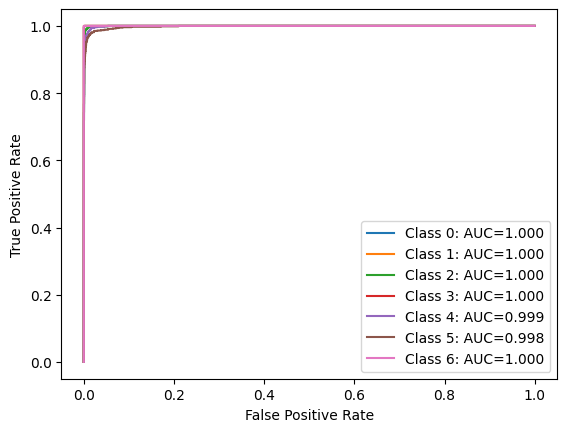

In [33]:
fpr = {}
tpr = {}
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i], drop_intermediate=False)
    roc_auc[i] = auc(fpr[i], tpr[i])


# plot the ROC curve for each class
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label='Class {}: AUC={:.3f}'.format(i, roc_auc[i]))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## MCC and Kappa Score

In [34]:
from sklearn.metrics import matthews_corrcoef, cohen_kappa_score

# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
mcc = matthews_corrcoef(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
print("MCC: {:.2f}%".format(mcc*100))
print("Kappa Score: {:.2f}%".format(kappa*100))

MCC: 98.30%
Kappa Score: 98.30%


In [35]:
### Individual Class Wise MCC and Kappa

from sklearn.metrics import confusion_matrix, matthews_corrcoef, cohen_kappa_score
# y_true are the true labels of the test set
# y_pred are the predicted labels of the test set
conf_mat = confusion_matrix(y_true, y_pred)
mcc_per_class = {}
kappa_per_class = {}

for i in range(len(conf_mat)):
    tp = conf_mat[i][i]
    fp = sum(conf_mat[:, i]) - tp
    fn = sum(conf_mat[i, :]) - tp
    tn = sum(sum(conf_mat)) - tp - fp - fn

    mcc_per_class[i] = matthews_corrcoef([1 if x==i else 0 for x in y_true], [1 if x==i else 0 for x in y_pred])
    kappa_per_class[i] = cohen_kappa_score([1 if x==i else 0 for x in y_true], [1 if x==i else 0 for x in y_pred])

print("MCC per class:")
for i, mcc in mcc_per_class.items():
    print("Class {}: {:.2f}%".format(i, mcc*100))

print("Kappa Score per class:")
for i, kappa in kappa_per_class.items():
    print("Class {}: {:.2f}%".format(i, kappa*100))

MCC per class:
Class 0: 99.56%
Class 1: 99.71%
Class 2: 97.96%
Class 3: 99.93%
Class 4: 96.26%
Class 5: 94.91%
Class 6: 99.92%
Kappa Score per class:
Class 0: 99.56%
Class 1: 99.70%
Class 2: 97.95%
Class 3: 99.93%
Class 4: 96.26%
Class 5: 94.90%
Class 6: 99.92%
